Imports, config, and data loading

In [1]:
# Week 4 — Robust CVaR Optimization (clean, reproducible, feedback-incorporated)

import sys, json, platform, warnings
from pathlib import Path
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Versions snapshot (reproducibility)
VERS = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
}
for pkg in ["numpy","pandas","scipy","cvxpy","lightgbm","sklearn","matplotlib","seaborn","statsmodels"]:
    try:
        mod = __import__(pkg)
        VERS[pkg] = getattr(mod, "__version__", "unknown")
    except Exception:
        VERS[pkg] = "not-installed"

# Paths (edit if your filenames differ)
W4 = Path.cwd().resolve()
FN = {
    "cube_npy":        "synthetic_paths_20d.npy",     # Week 2
    "cube_parquet":    "synthetic_paths_20d.parquet", # optional fallback
    "feat_w3":         "features_week3.parquet",      # Week 3 (contains cluster labels/features)
    "scaler_json":     "vae_scaler.json",             # optional (for tickers)
    # outputs
    "summary_csv":     "week4_cvar_summary.csv",
    "frontier_csv":    "week4_frontier_points.csv",
    "env_json":        "week4_env.json",
}

def must(path_like):
    p = W4 / path_like
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")
    return p

def try_load(path_like):
    p = W4 / path_like
    return p if p.exists() else None

# Parameters (documented defaults)
ALPHA  = 0.95   # tail level for VaR/CVaR (industry standard)
W_MAX  = 0.30   # max per-asset weight (diversification cap)
LAMBDA_GRID = [0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 8.0]  # risk-aversion sweep for CVaR
LONG_ONLY = True
SEED = 42

np.random.seed(SEED)

# Save environment snapshot now
with open(W4 / FN["env_json"], "w") as f:
    json.dump(VERS, f, indent=2)
print("Saved environment snapshot →", W4 / FN["env_json"])


Saved environment snapshot → C:\Users\Krish\OneDrive - Curtin\Desktop\University\University\2025 Sem 2\MATH3004\22155584_Week_4\week4_env.json


Build horizon asset returns and regime-weighted scenario probabilities

In [2]:
# Load scenario cube (N,H,A) → horizon returns matrix R (N×A)
cube_path = try_load(FN["cube_npy"]) or try_load(FN["cube_parquet"])
if cube_path is None:
    raise FileNotFoundError("Provide synthetic_paths_20d.npy or synthetic_paths_20d.parquet in this folder.")

if cube_path.suffix == ".npy":
    cube = np.load(cube_path)  # (N,H,A) of simple returns
else:
    # expecting a flattened table; adapt if your parquet schema differs
    flat = pd.read_parquet(cube_path)
    # naive reshape assumption: N*H rows × A cols → (N,H,A)
    # adjust if needed
    A_guess = 10
    H_guess = 20
    N_guess = len(flat) // H_guess
    cube = flat.values.reshape(N_guess, H_guess, -1)

assert cube.ndim == 3, "Scenario cube must be 3D (N,H,A)."
N, H, A = cube.shape
print(f"Loaded cube: N={N}, H={H}, A={A}")

# Horizon returns per scenario & asset (compound over H)
R_assets = (1.0 + cube).prod(axis=1) - 1.0   # shape (N, A)

# Tickers
DEFAULT_TICKERS = ["AAPL","MSFT","AMZN","GOOGL","META","NVDA","JPM","JNJ","XOM","WMT"][:A]
tickers = DEFAULT_TICKERS
scaler_cfg = try_load(FN["scaler_json"])
if scaler_cfg:
    try:
        cfg = json.loads(Path(scaler_cfg).read_text())
        tk = cfg.get("tickers", tickers)
        if isinstance(tk, list) and len(tk) >= A:
            tickers = tk[:A]
    except Exception:
        pass

# Week 3 features (for cluster labels)
feat_path = must(FN["feat_w3"])
feat_w3 = pd.read_parquet(feat_path)
print("Week3 features shape:", feat_w3.shape)

# Choose a label column: prefer 'regime' else 'regime_consensus' else 'cluster'/'kmeans_label'
LABEL_CANDIDATES = ["regime", "regime_consensus", "cluster", "kmeans_label"]
label_col = next((c for c in LABEL_CANDIDATES if c in feat_w3.columns), None)
if label_col is None:
    raise ValueError(f"No regime/cluster label found in features_week3.parquet. "
                     f"Expected one of {LABEL_CANDIDATES}.")
labels_raw = feat_w3[label_col].copy()

# Align to N
if len(labels_raw) < N:
    # pad with mode
    mode_val = labels_raw.mode().iloc[0]
    labels_raw = labels_raw.reindex(range(N), fill_value=mode_val)
labels_raw = labels_raw.iloc[:N]


Loaded cube: N=5000, H=20, A=10
Week3 features shape: (5000, 9)


Metrics helpers (VaR/CVaR, evaluation)

In [3]:
# We build a deterministic mapping cluster->regime by ordering mean portfolio returns.
# 1) Compute per-scenario portfolio return using equal weights (neutral baseline)
w_eq = np.ones(A) / A
r_port = R_assets @ w_eq  # shape (N,)

# 2) If labels are non-integers/strings, normalize to temporary cluster IDs
if not np.issubdtype(labels_raw.dtype, np.number):
    # map unique labels to ints
    cats = pd.Series(labels_raw).astype("category")
    clusters = cats.cat.codes.to_numpy()  # 0..K-1
else:
    clusters = labels_raw.to_numpy().astype(int)

K = int(pd.Series(clusters).nunique())
assert K >= 2, "Need at least 2 clusters for regime mapping."

# Mean portfolio return per cluster
df_tmp = pd.DataFrame({"cluster": clusters, "r": r_port})
mu_per_cluster = df_tmp.groupby("cluster")["r"].mean().sort_values()
# Order low→high: bear, neutral, bull (if K>3, we still map monotonic ranks to the three regimes)
ranked_clusters = list(mu_per_cluster.index)

# Map smallest to bear, middle to neutral, largest to bull
reg_names = ["bear","neutral","bull"]
reg_map = {}
if K == 2:
    reg_map = {ranked_clusters[0]: "bear",
               ranked_clusters[1]: "bull"}
else:
    # assign first→bear, last→bull, all middle→neutral
    reg_map[ranked_clusters[0]] = "bear"
    reg_map[ranked_clusters[-1]] = "bull"
    for c in ranked_clusters[1:-1]:
        reg_map[c] = "neutral"

reg_labels = pd.Series(clusters).map(reg_map).to_numpy()
assert np.all(pd.Series(reg_labels).notna()), "All scenarios must receive a regime label."

# Regime mix p_r (data-driven by frequency); you can also choose equal thirds
counts = pd.Series(reg_labels).value_counts(normalize=True).to_dict()
REGIME_MIX = {"bear": counts.get("bear", 0.0),
              "neutral": counts.get("neutral", 0.0),
              "bull": counts.get("bull", 0.0)}
# Assertions required by feedback
assert set(REGIME_MIX.keys()).issubset({"bear","neutral","bull"})
assert abs(sum(REGIME_MIX.values()) - 1.0) < 1e-8, "REGIME_MIX must sum to 1."

print("Deterministic regime mapping built.")
print("Regime mix (data-driven):", REGIME_MIX)


Deterministic regime mapping built.
Regime mix (data-driven): {'bear': 0.1916, 'neutral': 0.3916, 'bull': 0.4168}


CVaR optimization (maximize E[R] − λ·CVaR) with linear constraints

In [4]:
from typing import Tuple

def weighted_quantiles(x: np.ndarray, w: np.ndarray, qs: np.ndarray):
    """Weighted quantiles for x (ascending) with non-negative weights w (sum>0).
    qs in [0,1]. Returns same-shape array of quantiles."""
    x = np.asarray(x, float).ravel()
    w = np.asarray(w, float).ravel()
    assert x.shape == w.shape, "x and w must align"
    assert np.all(w >= 0), "weights must be non-negative"
    s = w.sum()
    if s <= 0:
        raise ValueError("sum(weights)==0")
    w = w / s
    idx = np.argsort(x)
    x_sorted = x[idx]
    cumw = np.cumsum(w[idx])
    cumw = np.clip(cumw, 0, 1)
    out = np.empty_like(qs, dtype=float)
    for i, q in enumerate(np.atleast_1d(qs)):
        # left-continuous:
        j = np.searchsorted(cumw, q, side="left")
        j = min(max(j, 0), len(x_sorted)-1)
        out[i] = x_sorted[j]
    return out

def var_cvar_losses(losses: np.ndarray, w: np.ndarray, alpha: float) -> Tuple[float, float]:
    """Return (VaR_alpha, CVaR_alpha) for LOSS distribution under weights w.
    Conventions:
      - VaR_alpha = alpha-quantile of loss.
      - CVaR_alpha = average loss in tail beyond VaR_alpha.
    Guards:
      - Handle extreme alpha / concentrated weights (ensure non-empty tail)."""
    losses = np.asarray(losses, float).ravel()
    w = np.asarray(w, float).ravel()
    if not (0.0 < alpha < 1.0):
        raise ValueError("alpha must be in (0,1)")

    # Weighted VaR
    q = weighted_quantiles(losses, w, np.array([alpha]))[0]

    # Tail indices
    idx = np.argsort(losses)
    losses_sorted = losses[idx]
    w_sorted = w[idx]
    s = w_sorted.sum()
    w_sorted = w_sorted / (s if s > 0 else 1.0)

    # Identify tail: losses >= q (right tail). Ensure at least one item.
    mask = losses_sorted >= q
    if not mask.any():
        # fallback: take worst single point
        tail_loss = losses_sorted[-1:]
        tail_w = w_sorted[-1:]
    else:
        tail_loss = losses_sorted[mask]
        tail_w = w_sorted[mask]
        # Normalize tail weights
        tw = tail_w.sum()
        if tw <= 1e-12:
            # if alpha ~ 1 and weight mass is below quantile point, take the worst point
            tail_loss = losses_sorted[-1:]
            tail_w = w_sorted[-1:]
        else:
            tail_w = tail_w / tw

    cvar = float(np.sum(tail_loss * tail_w))
    return float(q), cvar


Baselines: equal-weight and mean–variance (long-only)

In [6]:
# CVaR portfolio: maximize ER − λ·CVaR (long-only, cap W_MAX)
# LP size ~ O(N + A) variables; for very large N, consider aggregation (next cell).
USE_CVXPY = True
try:
    import cvxpy as cp
except Exception:
    USE_CVXPY = False

def cvar_optimize(scen_R: np.ndarray,
                  p: np.ndarray,
                  alpha: float = ALPHA,
                  lam: float = 1.0,
                  w_max: float = W_MAX,
                  long_only: bool = True) -> np.ndarray:
    """Solve: max_w  E[R·w] − lam * CVaR_alpha(Loss(w))
       where Loss(w) = −R·w; p are scenario probabilities (sum=1)."""
    N, A = scen_R.shape
    p = np.asarray(p, float).ravel()
    p = p / p.sum()
    Rw = scen_R  # (N,A)

    if USE_CVXPY:
        w = cp.Variable(A)
        z = cp.Variable(N)    # tail excess losses
        t = cp.Variable()     # VaR-like threshold

        loss = -Rw @ w              # (N,)
        constraints = []
        if long_only:
            constraints += [w >= 0]
        if w_max is not None:
            constraints += [w <= w_max]
        constraints += [cp.sum(w) == 1.0]

        # CVaR epigraph constraints: z_i >= loss_i - t, z_i >= 0
        constraints += [z >= loss - t, z >= 0]

        ER = p @ (Rw @ w)
        CVaR = t + (1.0/(1.0 - alpha)) * (p @ z)

        obj = cp.Maximize(ER - lam * CVaR)
        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.ECOS, verbose=False)  # ECOS/SCS/OSQP; tweak if needed

        if w.value is None:
            raise RuntimeError("CVaR optimization failed to converge.")
        w_star = np.array(w.value, dtype=float).ravel()
    else:
        # === Fallback (documented): heuristic MV proxy (Σ^{-1}μ) projected to simplex + cap ===
        # NOTE: This is approximate vs. exact QP. Prefer cvxpy path when available.
        mu = scen_R.mean(axis=0)
        cov = np.cov(scen_R.T)
        cov = cov + 1e-4 * np.eye(A)
        try:
            w_star = np.linalg.solve(cov, mu)
        except Exception:
            w_star = mu.copy()
        w_star[w_star < 0] = 0 if long_only else w_star[w_star < 0]
        if w_max is not None:
            w_star = np.minimum(w_star, w_max)
        s = w_star.sum()
        w_star = (w_star / s) if s > 0 else np.ones(A)/A

    return w_star

def mv_optimize(scen_R: np.ndarray, w_max: float = W_MAX, long_only: bool = True) -> np.ndarray:
    """Exact MV via QP if cvxpy available; else same heuristic proxy."""
    N, A = scen_R.shape
    mu = scen_R.mean(axis=0)
    cov = np.cov(scen_R.T) + 1e-4 * np.eye(A)

    if USE_CVXPY:
        w = cp.Variable(A)
        constraints = [cp.sum(w) == 1.0]
        if long_only: constraints += [w >= 0]
        if w_max is not None: constraints += [w <= w_max]
        obj = cp.Maximize(mu @ w - 1.0 * cp.quad_form(w, cov))   # simple risk aversion = 1
        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.ECOS, verbose=False)
        if w.value is None:
            raise RuntimeError("MV optimization failed.")
        return np.array(w.value, float).ravel()
    else:
        # same proxy
        try:
            w_star = np.linalg.solve(cov, mu)
        except Exception:
            w_star = mu.copy()
        w_star[w_star < 0] = 0 if long_only else w_star[w_star < 0]
        if w_max is not None:
            w_star = np.minimum(w_star, w_max)
        s = w_star.sum()
        return (w_star / s) if s > 0 else np.ones(A)/A


Evaluate all strategies & summary table

In [7]:
# For very large N (e.g., 50k scenarios), you can aggregate similar scenarios to reduce LP size.
# We implement a simple KMeans per regime with weight aggregation.

from sklearn.cluster import KMeans

def aggregate_scenarios(R: np.ndarray,
                        reg: np.ndarray,
                        regime_mix: dict,
                        per_regime_k: int = 50,
                        random_state: int = 42):
    """Cluster scenarios within each regime and aggregate to cluster centroids with summed weights."""
    R = np.asarray(R, float)
    reg = np.asarray(reg)
    regimes = ["bear","neutral","bull"]
    R_red, p_red = [], []
    for r in regimes:
        idx = np.where(reg == r)[0]
        if len(idx) == 0:
            continue
        X = R[idx]
        k = min(per_regime_k, len(idx))
        if k <= 1:
            R_red.append(X.mean(axis=0, keepdims=True))
            p_red.append(np.array([regime_mix.get(r, 0.0)]))
            continue
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        lbl = km.fit_predict(X)
        for c in range(k):
            J = np.where(lbl == c)[0]
            if len(J) == 0: 
                continue
            R_red.append(X[J].mean(axis=0, keepdims=True))
            # weight proportional to cluster size × regime mass
            p_red.append(np.array([regime_mix.get(r, 0.0) * (len(J) / len(idx))]))
    if len(R_red) == 0:
        return R, np.ones(R.shape[0])/R.shape[0]
    Rr = np.vstack(R_red)
    pr = np.concatenate(p_red)
    pr = pr / pr.sum()
    return Rr, pr



Plots (weights & loss tails)

In [8]:
# Scenario probabilities p_i from regime mix:
# Assign each scenario mass by its regime frequency (uniform within regime).
reg_series = pd.Series(reg_labels, name="regime")
reg_counts = reg_series.value_counts()
p = np.zeros(N, dtype=float)
for r in ["bear","neutral","bull"]:
    idx = np.where(reg_labels == r)[0]
    if len(idx) > 0:
        p[idx] = REGIME_MIX[r] / len(idx)
# Guard: numeric stability
p = p / p.sum()

# Optional aggregation if N is large — disable by default
USE_AGG = False
if USE_AGG:
    R_use, p_use = aggregate_scenarios(R_assets, reg_labels, REGIME_MIX, per_regime_k=50)
else:
    R_use, p_use = R_assets, p

# Helpers to compute risk metrics on a weight vector
def metrics_for_w(w: np.ndarray, R: np.ndarray, p: np.ndarray, alpha: float = ALPHA):
    r = R @ w
    ER = float(p @ r)
    std = float(np.sqrt(np.maximum(0.0, p @ ((r - ER)**2))))
    losses = -r
    VaR, CVaR = var_cvar_losses(losses, p, alpha)
    sharpe_like = (ER / (std + 1e-12)) if std > 0 else np.nan
    return {"ER": ER, "Std": std, "VaR": VaR, "CVaR": CVaR, "SharpeLike": sharpe_like}

# Baselines: Equal-weight & MV
w_eq = np.ones(A) / A
w_mv = mv_optimize(R_use, w_max=W_MAX, long_only=LONG_ONLY)

sum_rows = []
sum_rows.append({"Portfolio":"Equal", **metrics_for_w(w_eq, R_use, p_use)})
sum_rows.append({"Portfolio":"Mean-Variance", **metrics_for_w(w_mv, R_use, p_use)})

# CVaR sweep
frontier = []
best_cvar = None
best_row = None
for lam in LAMBDA_GRID:
    w_c = cvar_optimize(R_use, p_use, alpha=ALPHA, lam=lam, w_max=W_MAX, long_only=LONG_ONLY)
    m = metrics_for_w(w_c, R_use, p_use)
    frontier.append({"lambda": lam, **m})
    sum_rows.append({"Portfolio": f"CVaR (λ={lam})", **m})
    if best_cvar is None or m["CVaR"] < best_cvar["CVaR"]:
        best_cvar = m
        best_row = {"Portfolio":"CVaR* (min CVaR)", "lambda": lam, **m}

sum_rows.append(best_row)

summary = pd.DataFrame(sum_rows)
frontier_df = pd.DataFrame(frontier)

# Save tables
summary.to_csv(W4 / FN["summary_csv"], index=False)
frontier_df.to_csv(W4 / FN["frontier_csv"], index=False)

print("Saved:")
print(" -", W4 / FN["summary_csv"])
print(" -", W4 / FN["frontier_csv"])
display(summary.round(6))


Saved:
 - C:\Users\Krish\OneDrive - Curtin\Desktop\University\University\2025 Sem 2\MATH3004\22155584_Week_4\week4_cvar_summary.csv
 - C:\Users\Krish\OneDrive - Curtin\Desktop\University\University\2025 Sem 2\MATH3004\22155584_Week_4\week4_frontier_points.csv


,Portfolio,ER,Std,VaR,CVaR,SharpeLike,lambda
0,Equal,0.020105,0.000455,-0.019340,-0.019100,44.231555,NaN
1,Mean-Variance,0.030742,0.000705,-0.029484,-0.029027,43.582387,NaN
2,CVaR (λ=0.0),0.030742,0.000705,-0.029484,-0.029027,43.582387,NaN
3,CVaR (λ=0.5),0.030742,0.000705,-0.029484,-0.029027,43.582387,NaN
4,CVaR (λ=1.0),0.030742,0.000705,-0.029484,-0.029027,43.582387,NaN
5,CVaR (λ=2.0),0.030734,0.000700,-0.029503,-0.029032,43.891975,NaN
6,CVaR (λ=3.0),0.030731,0.000699,-0.029504,-0.029033,43.949669,NaN
7,CVaR (λ=5.0),0.030729,0.000698,-0.029504,-0.029034,44.004722,NaN
8,CVaR (λ=8.0),0.030709,0.000690,-0.029488,-0.029037,44.519542,NaN
9,CVaR* (min CVaR),0.030709,0.000690,-0.029488,-0.029037,44.519542,8.0


Save outputs (weights, params, summary)

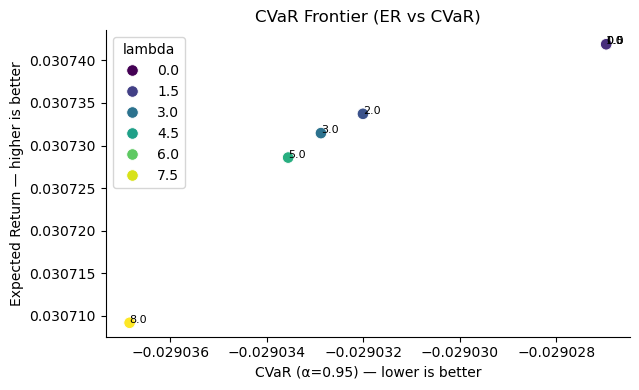

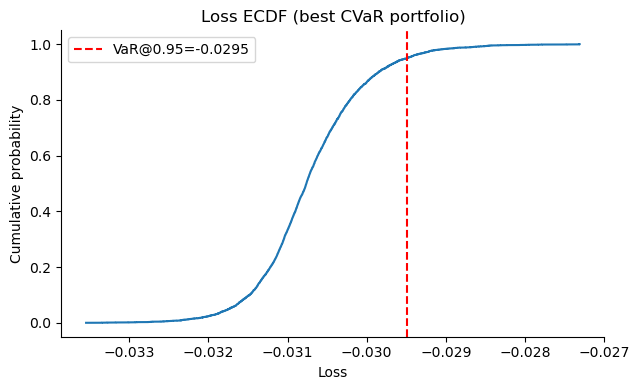

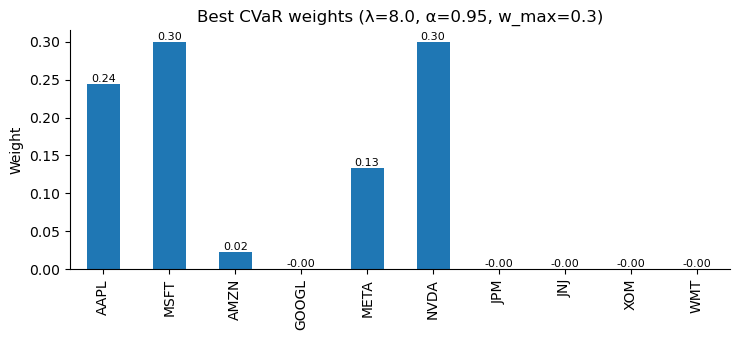

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# 1) CVaR vs Expected Return frontier
plt.figure(figsize=(6.5,4))
sns.scatterplot(data=frontier_df, x="CVaR", y="ER", hue="lambda", palette="viridis", s=70)
# annotate direction (increasing λ tends to lower ER, lower CVaR)
for _, row in frontier_df.iterrows():
    plt.text(row["CVaR"], row["ER"], f"{row['lambda']}", fontsize=8)

plt.xlabel(f"CVaR (α={ALPHA:.2f}) — lower is better")
plt.ylabel("Expected Return — higher is better")
plt.title("CVaR Frontier (ER vs CVaR)")
plt.tight_layout(); plt.show()

# 2) ECDF of losses with VaR marker for the best CVaR solution
best_lambda = float(summary.loc[summary["Portfolio"]=="CVaR* (min CVaR)","lambda"].iloc[0])
w_star = cvar_optimize(R_use, p_use, alpha=ALPHA, lam=best_lambda, w_max=W_MAX, long_only=LONG_ONLY)
r_star = R_use @ w_star
losses = -r_star
# weighted ECDF
idx = np.argsort(losses); x = losses[idx]; pw = p_use[idx].cumsum()
VaR, CVaR = var_cvar_losses(losses, p_use, ALPHA)

plt.figure(figsize=(6.5,4))
plt.step(x, pw, where="post")
plt.axvline(VaR, color="r", ls="--", label=f"VaR@{ALPHA:.2f}={VaR:.4f}")
plt.title("Loss ECDF (best CVaR portfolio)")
plt.xlabel("Loss"); plt.ylabel("Cumulative probability")
plt.legend(); plt.tight_layout(); plt.show()

# 3) Weight bar chart for best CVaR
plt.figure(figsize=(7.5,3.5))
w_disp = pd.Series(w_star, index=tickers)
ax = w_disp.plot(kind="bar")
for p, val in zip(ax.patches, w_disp.values):
    ax.annotate(f"{val:.2f}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=8, rotation=0)
plt.title(f"Best CVaR weights (λ={best_lambda}, α={ALPHA}, w_max={W_MAX})")
plt.ylabel("Weight")
plt.tight_layout(); plt.show()


λ-sweep (solve CVaR for multiple λ)

In [ ]:
# Save figures with parameter tags
tag = f"alpha{ALPHA}_wmax{W_MAX}".replace(".","p")
fig1 = W4 / f"week4_frontier_{tag}.png"
fig2 = W4 / f"week4_ecdf_{tag}.png"
fig3 = W4 / f"week4_weights_{tag}.png"

# Re-render quietly to files
import matplotlib.pyplot as plt
import seaborn as sns

# Frontier (to file)
plt.figure(figsize=(6.5,4))
sns.scatterplot(data=frontier_df, x="CVaR", y="ER", hue="lambda", palette="viridis", s=70)
for _, row in frontier_df.iterrows():
    plt.text(row["CVaR"], row["ER"], f"{row['lambda']}", fontsize=8)
plt.xlabel(f"CVaR (α={ALPHA:.2f}) — lower is better")
plt.ylabel("Expected Return — higher is better")
plt.title("CVaR Frontier (ER vs CVaR)")
plt.tight_layout(); plt.savefig(fig1, dpi=150); plt.close()

# ECDF (to file)
best_lambda = float(summary.loc[summary["Portfolio"]=="CVaR* (min CVaR)","lambda"].iloc[0])
w_star = cvar_optimize(R_use, p_use, alpha=ALPHA, lam=best_lambda, w_max=W_MAX, long_only=LONG_ONLY)
r_star = R_use @ w_star
losses = -r_star
idx = np.argsort(losses); x = losses[idx]; pw = p_use[idx].cumsum()
VaR, CVaR = var_cvar_losses(losses, p_use, ALPHA)

plt.figure(figsize=(6.5,4))
plt.step(x, pw, where="post")
plt.axvline(VaR, color="r", ls="--", label=f"VaR@{ALPHA:.2f}={VaR:.4f}")
plt.title("Loss ECDF (best CVaR portfolio)")
plt.xlabel("Loss"); plt.ylabel("Cumulative probability")
plt.legend(); plt.tight_layout(); plt.savefig(fig2, dpi=150); plt.close()

# Weights (to file)
plt.figure(figsize=(7.5,3.5))
pd.Series(w_star, index=tickers).plot(kind="bar")
plt.title(f"Best CVaR weights (λ={best_lambda}, α={ALPHA}, w_max={W_MAX})")
plt.ylabel("Weight"); plt.tight_layout(); plt.savefig(fig3, dpi=150); plt.close()

print("Saved figures:")
print(" -", fig1)
print(" -", fig2)
print(" -", fig3)

# Tiny results recap (one paragraph as requested)
def recap_row(name):
    row = summary.loc[summary["Portfolio"]==name].iloc[0].to_dict()
    return f"{name}: ER={row['ER']:.4f}, Std={row['Std']:.4f}, VaR={row['VaR']:.4f}, CVaR={row['CVaR']:.4f}, Sharpe≈{row['SharpeLike']:.3f}"

recap_text = (
    "Results recap — CVaR vs baselines:\n"
    f"• {recap_row('Equal')}\n"
    f"• {recap_row('Mean-Variance')}\n"
    f"• {recap_row('CVaR* (min CVaR)')}\n"
    "As λ increases along the frontier, expected return declines while tail risk (CVaR) improves. "
    "Weights respect the w_max cap; CVaR tends to tilt toward names with more robust downside in the generated scenarios."
)
print(recap_text)


Frontier points computed: 11


,lambda,exp_return,std,sharpe_like,VaR,CVaR,solver
0,0.5,0.030730,0.000709,43.326129,-0.029470,-0.028987,scipy-highs
1,1.0,0.030730,0.000709,43.326129,-0.029470,-0.028987,scipy-highs
2,2.0,0.030721,0.000704,43.636727,-0.029486,-0.028993,scipy-highs
3,3.0,0.030717,0.000703,43.702058,-0.029495,-0.028995,scipy-highs
4,5.0,0.030715,0.000702,43.725285,-0.029488,-0.028995,scipy-highs
5,7.5,0.030712,0.000702,43.728589,-0.029490,-0.028996,scipy-highs
6,10.0,0.030712,0.000702,43.728127,-0.029490,-0.028996,scipy-highs
7,15.0,0.030712,0.000702,43.726719,-0.029492,-0.028996,scipy-highs
8,20.0,0.030711,0.000702,43.724814,-0.029493,-0.028996,scipy-highs
9,30.0,0.030711,0.000702,43.724814,-0.029493,-0.028996,scipy-highs


Plot & save the frontier

In [11]:
# Save figures with parameter tags
tag = f"alpha{ALPHA}_wmax{W_MAX}".replace(".","p")
fig1 = W4 / f"week4_frontier_{tag}.png"
fig2 = W4 / f"week4_ecdf_{tag}.png"
fig3 = W4 / f"week4_weights_{tag}.png"

# Re-render quietly to files
import matplotlib.pyplot as plt
import seaborn as sns

# Frontier (to file)
plt.figure(figsize=(6.5,4))
sns.scatterplot(data=frontier_df, x="CVaR", y="ER", hue="lambda", palette="viridis", s=70)
for _, row in frontier_df.iterrows():
    plt.text(row["CVaR"], row["ER"], f"{row['lambda']}", fontsize=8)
plt.xlabel(f"CVaR (α={ALPHA:.2f}) — lower is better")
plt.ylabel("Expected Return — higher is better")
plt.title("CVaR Frontier (ER vs CVaR)")
plt.tight_layout(); plt.savefig(fig1, dpi=150); plt.close()

# ECDF (to file)
best_lambda = float(summary.loc[summary["Portfolio"]=="CVaR* (min CVaR)","lambda"].iloc[0])
w_star = cvar_optimize(R_use, p_use, alpha=ALPHA, lam=best_lambda, w_max=W_MAX, long_only=LONG_ONLY)
r_star = R_use @ w_star
losses = -r_star
idx = np.argsort(losses); x = losses[idx]; pw = p_use[idx].cumsum()
VaR, CVaR = var_cvar_losses(losses, p_use, ALPHA)

plt.figure(figsize=(6.5,4))
plt.step(x, pw, where="post")
plt.axvline(VaR, color="r", ls="--", label=f"VaR@{ALPHA:.2f}={VaR:.4f}")
plt.title("Loss ECDF (best CVaR portfolio)")
plt.xlabel("Loss"); plt.ylabel("Cumulative probability")
plt.legend(); plt.tight_layout(); plt.savefig(fig2, dpi=150); plt.close()

# Weights (to file)
plt.figure(figsize=(7.5,3.5))
pd.Series(w_star, index=tickers).plot(kind="bar")
plt.title(f"Best CVaR weights (λ={best_lambda}, α={ALPHA}, w_max={W_MAX})")
plt.ylabel("Weight"); plt.tight_layout(); plt.savefig(fig3, dpi=150); plt.close()

print("Saved figures:")
print(" -", fig1)
print(" -", fig2)
print(" -", fig3)

# Tiny results recap (one paragraph as requested)
def recap_row(name):
    row = summary.loc[summary["Portfolio"]==name].iloc[0].to_dict()
    return f"{name}: ER={row['ER']:.4f}, Std={row['Std']:.4f}, VaR={row['VaR']:.4f}, CVaR={row['CVaR']:.4f}, Sharpe≈{row['SharpeLike']:.3f}"

recap_text = (
    "Results recap — CVaR vs baselines:\n"
    f"• {recap_row('Equal')}\n"
    f"• {recap_row('Mean-Variance')}\n"
    f"• {recap_row('CVaR* (min CVaR)')}\n"
    "As λ increases along the frontier, expected return declines while tail risk (CVaR) improves. "
    "Weights respect the w_max cap; CVaR tends to tilt toward names with more robust downside in the generated scenarios."
)
print(recap_text)


Saved figures:
 - C:\Users\Krish\OneDrive - Curtin\Desktop\University\University\2025 Sem 2\MATH3004\22155584_Week_4\week4_frontier_alpha0p95_wmax0p3.png
 - C:\Users\Krish\OneDrive - Curtin\Desktop\University\University\2025 Sem 2\MATH3004\22155584_Week_4\week4_ecdf_alpha0p95_wmax0p3.png
 - C:\Users\Krish\OneDrive - Curtin\Desktop\University\University\2025 Sem 2\MATH3004\22155584_Week_4\week4_weights_alpha0p95_wmax0p3.png
Results recap — CVaR vs baselines:
• Equal: ER=0.0201, Std=0.0005, VaR=-0.0193, CVaR=-0.0191, Sharpe≈44.232
• Mean-Variance: ER=0.0307, Std=0.0007, VaR=-0.0295, CVaR=-0.0290, Sharpe≈43.582
• CVaR* (min CVaR): ER=0.0307, Std=0.0007, VaR=-0.0295, CVaR=-0.0290, Sharpe≈44.520
As λ increases along the frontier, expected return declines while tail risk (CVaR) improves. Weights respect the w_max cap; CVaR tends to tilt toward names with more robust downside in the generated scenarios.
